# Integration Validation

### AND Integration Test

Here we test the I/O integrated with an AND gate both in forward and reverse configuration.

In [1]:
from ogates import *
from io_osc import *
import sky130_hdl21 as sky130
from sitepdks import *
import vlsirtools.spice as vsp
import hdl21 as h
from hdl21.prefix import n, p

@h.sim.sim
class oAND_Sim:

    @h.module
    class Tb:

        # Instantiate power supplies, enable signal and reference signal
        VSS = h.Port()
        VDD = h.Signal()
        vdd  = h.PulseVoltageSource(
            delay=0,
            v1=0,
            v2=1.8,
            period=0,
            rise=10*n,
            fall=1*n,
            width=1
        )(p=VDD,n=VSS)
        CLK = h.Signal()
        clk = h.PulseVoltageSource(
            delay=81*n,
            v1=0,
            v2=1.8,
            period=0,
            rise=10*n,
            fall=1*n,
            width=1
        )(p=CLK,n=VSS)
        REF = h.Signal()
        aout = h.Signal(width=1)
        vout = h.Signal(width=1)

        stages = 31

        # Instantiate input vsources and oscillators and output phase detector
        DIGITAL_IN = digital_signal(width=2,inp=3)(VSS=VSS)
        IN  = gen_in_osc(stages=stages,n_bits=2)(VSS=VSS, VDD=VDD,REF=REF,IN=DIGITAL_IN.vout)

        # Define connection tensor
        Q = (
            (( 0, 1,-2),( 1, 2, 4),( 2, 3,-2),( 3, 0, 1)),
            (( 0, 1,-2),( 1, 3, 1),( 3, 2,-2),( 2, 0, 4)),
            (( 0, 2, 4),( 2, 1, 4),( 1, 3, 1),( 3, 0, 1)),
        )

        # Define node names
        nodes = ("A", "B", "C", "REF")

        # Instantiate AND gate
        oAND = gen_ogate(stages=stages, node_names=nodes, couplings=Q, gate_name="AND")

        # Instantiate AND gate
        AND = oAND(VDD=VDD,VSS=VSS,REF=REF,A=IN.OUT[0],B=IN.OUT[1],C=aout)

        # Instantiate outputs
        OUT = gen_out_osc(stages=stages,n_bits=1)(VDD=VDD,VSS=VSS,CLK=CLK,REF=REF,IN=aout,OUT=vout)

    # Simulation Controls
    tran = h.sim.Tran(tstop=200*n, tstep=1*p)
    inc_base = sky130.install.include(h.pdk.Corner.TYP)
    inc_cells = h.sim.Include(
            sky130.install.pdk_path /
            "libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice"
    )

opts = vsp.SimOptions(
    simulator=vsp.SupportedSimulators.NGSPICE,
        fmt=vsp.ResultFormat.SIM_DATA,
        rundir="./scratch",
    )

rv = oAND_Sim.run(opts)
op = rv[vsp.sim_data.AnalysisType.TRAN]

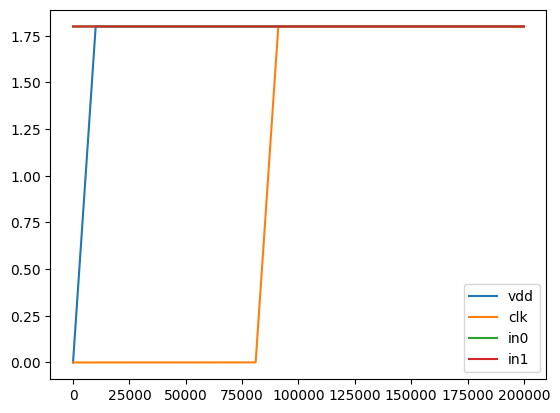

In [2]:
import matplotlib.pyplot as plt

plt.plot(op.data['v(xtop.vdd)'])
plt.plot(op.data['v(xtop.clk)'])
plt.plot(op.data['v(xtop.digital_in_vout_0)'])
plt.plot(op.data['v(xtop.digital_in_vout_1)'])
plt.legend(['vdd', 'clk', 'in0', 'in1'])

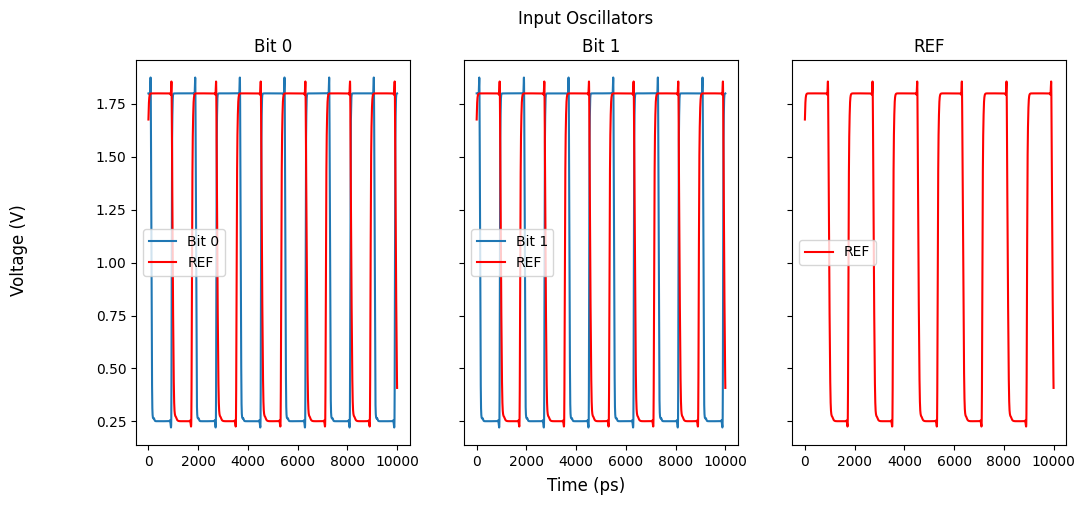

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True) # Increased the width

start = -10000
stop = -1

axs[0].plot(op.data['v(xtop.in_out_0)'][start:stop])
axs[0].plot(op.data['v(xtop.ref)'][start:stop],color='red')
axs[0].legend(['Bit 0','REF'])
axs[0].set_title('Bit 0')

axs[1].plot(op.data['v(xtop.in_out_1)'][start:stop])
axs[1].plot(op.data['v(xtop.ref)'][start:stop],color='red')
axs[1].legend(['Bit 1','REF'])
axs[1].set_title('Bit 1')

# Create a new subplot for REF
axs[2].plot(op.data['v(xtop.ref)'][start:stop],color='red')
axs[2].legend(['REF'])
axs[2].set_title('REF')

plt.suptitle('Input Oscillators')

fig.supxlabel('Time (ps)')
fig.supylabel('Voltage (V)')

plt.show()


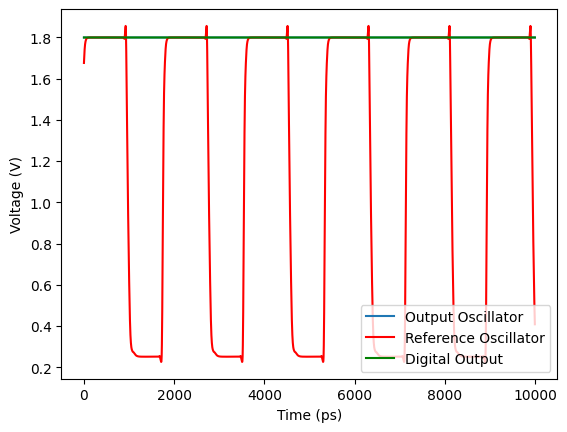

In [4]:
plt.plot(op.data['v(xtop.aout)'][start:stop])
plt.plot(op.data['v(xtop.ref)'][start:stop],color='red')
plt.plot(op.data['v(xtop.vout)'][start:stop],color='green')
plt.xlabel('Time (ps)')
plt.ylabel('Voltage (V)')
plt.legend(['Output Oscillator','Reference Oscillator','Digital Output'],loc='lower right')